In [1]:
import cv2
import pytesseract
import numpy as np
import cv2
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from local_utils import detect_lp
from os.path import splitext,basename
from keras.models import model_from_json
import glob
from paddleocr import PaddleOCR

Loading model successfully...


2023-11-18 16:59:00.306581: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


1/1 [==============================] - 0s 320ms/step


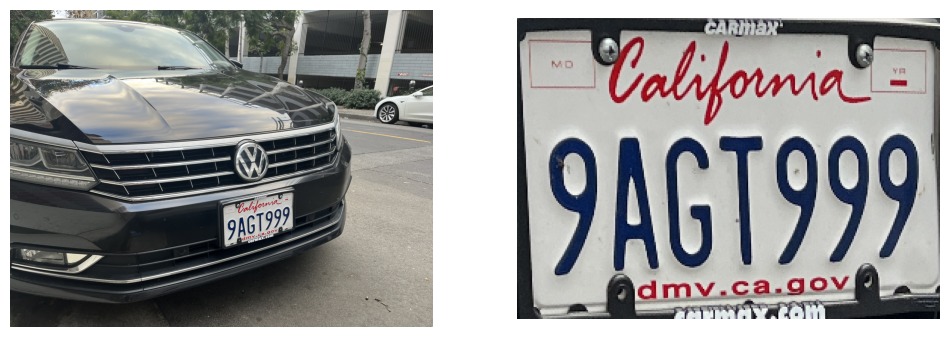

In [3]:
def load_model(path):
    try:
        path = splitext(path)[0]
        with open('%s.json' % path, 'r') as json_file:
            model_json = json_file.read()
        model = model_from_json(model_json, custom_objects={})
        model.load_weights('%s.h5' % path)
        print("Loading model successfully...")
        return model
    except Exception as e:
        print(e)

wpod_net_path = "wpod-net.json"
wpod_net = load_model(wpod_net_path)

def preprocess_image(image_path,resize=False):
    img = cv2.imread(image_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = img / 255
    if resize:
        img = cv2.resize(img, (224,224))
    return img

def get_plate(image_path, Dmax=608, Dmin=256):
    vehicle = preprocess_image(image_path)
    ratio = float(max(vehicle.shape[:2])) / min(vehicle.shape[:2])
    side = int(ratio * Dmin)
    bound_dim = min(side, Dmax)
    _ , LpImg, _, cor = detect_lp(wpod_net, vehicle, bound_dim, lp_threshold=0.5)
    return vehicle, LpImg, cor

#这里用来导入测试用的车牌
test_image_path = "IMG_0519.JPG"
# test_image_path = "9AGT999.JPG"
# test_image_path = "Plate_examples/usa_car_plate.jpg"
# test_image_path = "Plate_examples/car.png"
vehicle, LpImg,cor = get_plate(test_image_path)

fig = plt.figure(figsize=(12,6))
grid = gridspec.GridSpec(ncols=2,nrows=1,figure=fig)
fig.add_subplot(grid[0])
plt.axis(False)
plt.imshow(vehicle)
grid = gridspec.GridSpec(ncols=2,nrows=1,figure=fig)
fig.add_subplot(grid[1])
plt.axis(False)
plt.imshow(LpImg[0])

[2023/11/18 16:59:16] ppocr DEBUG: Namespace(help='==SUPPRESS==', use_gpu=False, use_xpu=False, ir_optim=True, use_tensorrt=False, min_subgraph_size=15, shape_info_filename=None, precision='fp32', gpu_mem=500, image_dir=None, det_algorithm='DB', det_model_dir='/Users/jxx/.paddleocr/whl/det/en/en_PP-OCRv3_det_infer', det_limit_side_len=960, det_limit_type='max', det_db_thresh=0.3, det_db_box_thresh=0.6, det_db_unclip_ratio=1.5, max_batch_size=10, use_dilation=False, det_db_score_mode='fast', det_east_score_thresh=0.8, det_east_cover_thresh=0.1, det_east_nms_thresh=0.2, det_sast_score_thresh=0.5, det_sast_nms_thresh=0.2, det_sast_polygon=False, det_pse_thresh=0, det_pse_box_thresh=0.85, det_pse_min_area=16, det_pse_box_type='quad', det_pse_scale=1, scales=[8, 16, 32], alpha=1.0, beta=1.0, fourier_degree=5, det_fce_box_type='poly', rec_algorithm='CRNN', rec_model_dir='/Users/jxx/.paddleocr/whl/rec/en/en_PP-OCRv3_rec_infer', rec_image_shape='3, 48, 320', rec_batch_num=6, max_text_length=25

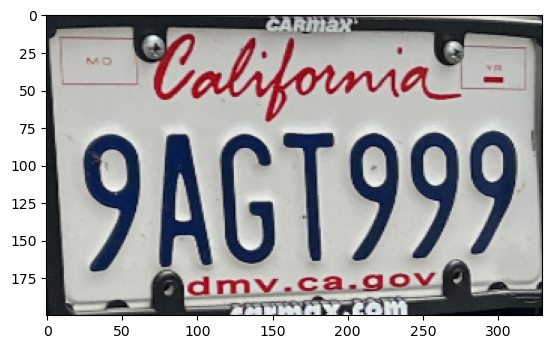

In [4]:
ocr = PaddleOCR(lang='en',rec_algorithm='CRNN')
LpImg[0].shape
image = cv2.resize(LpImg[0], (330, 200))
image = np.uint8(image * 255)
plt.imshow(image)
result = ocr.ocr(image, cls=False, det=False)
ocr_res = result[0][0]
print(ocr_res)

In [30]:
#测试集导入 文件路径在image_paths中 标签在labels中
image_paths = glob.glob("testImg/*.jpg")
print("Found %i images..."%(len(image_paths)))
labels = [image_path.split('/')[1].split('.')[0] for image_path in image_paths]
print(labels)

Found 16 images...
['2AQC214', '5A22845', '4ABC123', '8TRS777', '2ABNO71', '3SAM123', 'WP21854', 'KPH5555', '8QRA64', '6TRJ244', '7KKJ9O1', '5M3725O', 'JUSTDGF', '7RSVO7O', '1ABC123', '7LYU892']


In [ ]:
# 这个是从整体的图片测试集中提取车牌到test_res中，测试集还没做
test_res = [ocr.ocr(np.uint8(get_plate(image_path)[1][0] * 255), cls=False, det=False)[0][0] for image_path in image_paths]
print(test_res)

In [31]:
#这个是直接从车牌图片上提取
test_res = [ocr.ocr(cv2.imread(image_path), cls=False, det=False)[0][0] for image_path in image_paths]
print(test_res)

['(ZAQC21Z)', 'EA228LS', 'ZABC123', 'BiS7', 'ZABNOT', '3SAM123', 'MP2185L', 'KPH555]', '" 8ORA62', '6TRJZLL', '7kKJ9OI', 'SM37250', 'USTOCFP', 'TRSVO7O', '"1AC 123', 'LYU892']


In [32]:
def accuracy(labels, test_res):
    if len(labels) != len(test_res):
        print("err: labels and test_res should have the same length")
        return 0
    allCh, corCh = 0, 0
    for i in range(len(labels)):
        label = labels[i]
        res = test_res[i]
        allCh += len(label)
        for ch in res:
            if ch in label:
                corCh += 1
            elif ch == "0" and "O" in label:
                corCh += 1
    return corCh / allCh

In [33]:
print(accuracy(labels, test_res))

0.7207207207207207


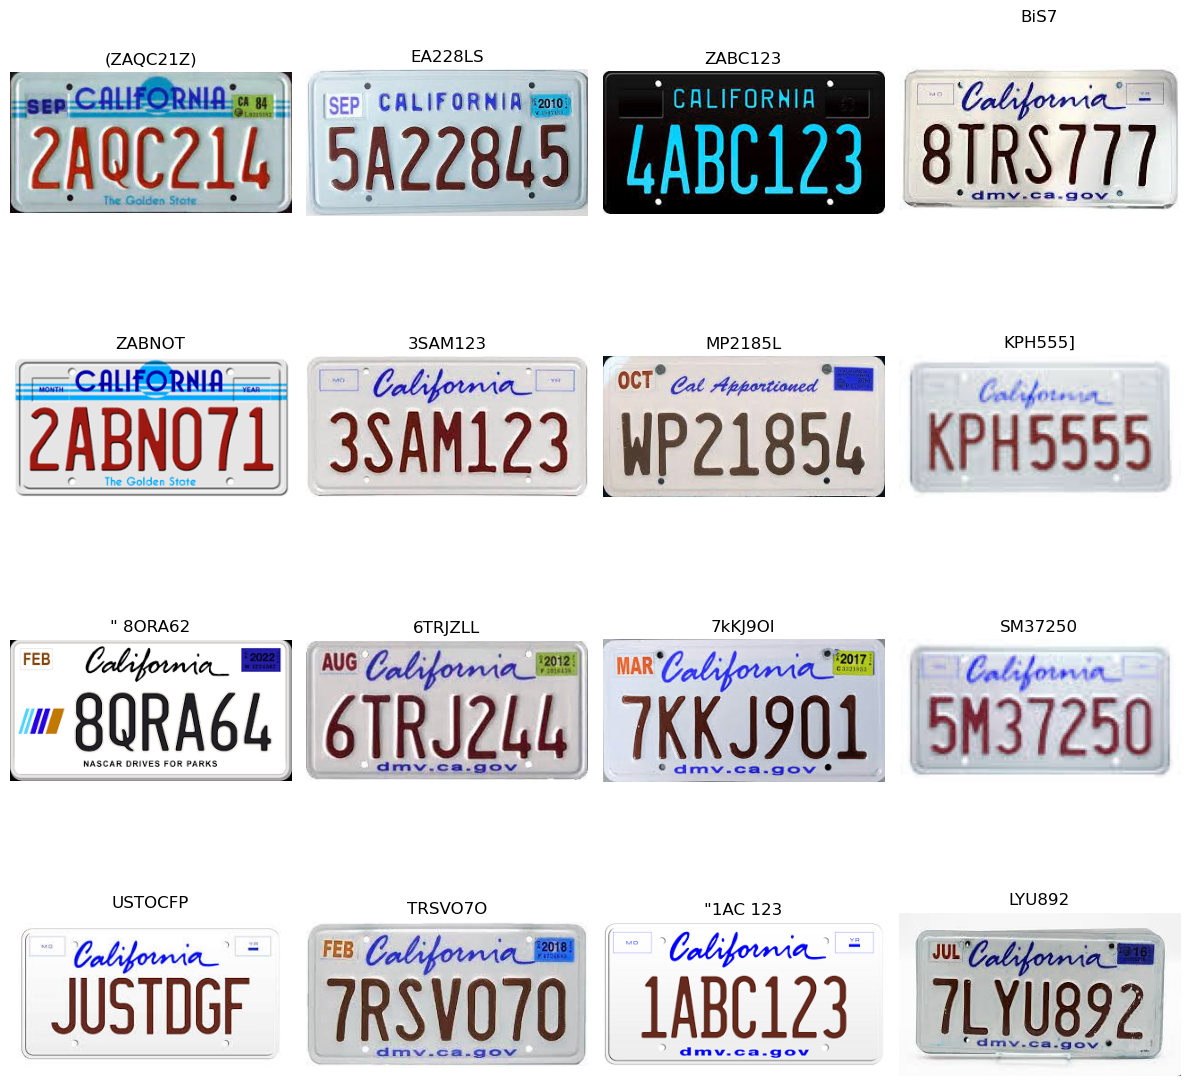

In [34]:
fig = plt.figure(figsize=(12,12))
cols = 4
rows = 4
fig_list = []
for i in range(cols*rows):
    fig_list.append(fig.add_subplot(rows,cols,i+1))
    title = test_res[i]
    fig_list[-1].set_title(title)
    img = cv2.imread(image_paths[i])
    plt.axis(False)
    plt.imshow(img)

plt.tight_layout()
plt.show()